# Computation of the sensitivity matrix
This notebook shows how to compute the sensitivity matrix from true coincidences selected using the function `antea.reco.reco_functions.select_coincidences_trueinfo`. The procedure is as follows:

- Generate $N_f$ true Geant output files using the sensitivity map grid stepper in Nexus, which launches $N_p$ points along a specified grid over a given volume. The total number of gammas generated per point is then specified below (as `NPTS`) and is equal to $N_f \times N_p$.
- Run `antea.reco.reco_functions.select_coincidences_trueinfo` and save the resulting coincident event information in a pytable containing at least the emission vertex in columns `trux_v1x`, `true_v1y`, and `true_v1z`
- Combine the .h5 files produced (one for each Nexus file) using the function `combine_datafiles` below
- Run the code below to generate the matrix for the specified field of view and voxel numbers (note that these must match those of the image to be reconstructed later)

The resulting sensitivity matrix is resampled using `scipy.ndimage.zoom` and saved as a numpy array `.npz` so that it can be later loaded and used in image reconstruction.

In [1]:
# Add the line below so that plots will appear inline in the notebook.
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy  as np
import os
import tables as tb
import pandas as pd

from glob import glob
from scipy.ndimage import zoom

## Set relevant parameters
The `FOV_XY`, `FOV_Z`, `NXY`, and `NZ` parameters should be the same as those that will be passed to the reconstruction.

In [2]:
FOV_XY = 180.
FOV_Z = 180.
NXY = 60
NZ = 60

NPTS = 100000 # total number of points generated per grid location

## Functions for later use

In [3]:
def plot_projections(smat,xy_nbins,z_nbins,xy_fov,z_fov):
    
    xslice = int(xy_nbins/2)
    yslice = int(xy_nbins/2)
    zslice = int(z_nbins/2)
    xy_ext = [-xy_fov/2.,xy_fov/2.,-xy_fov/2.,xy_fov/2.]
    xz_ext = [-xy_fov/2.,xy_fov/2.,-z_fov/2. ,z_fov/2. ]
    yz_ext = [-xy_fov/2.,xy_fov/2.,-z_fov/2. ,z_fov/2. ]

    # Create a new figure.
    fig = plt.figure()
    fig.patch.set_alpha(0.0)
    fig.set_figheight(5.0)
    fig.set_figwidth(20.0)

    # Draw the x-y projection.
    ax1 = fig.add_subplot(131)
    xyhst = smat[:,:,zslice]*100
    plt.imshow(xyhst.transpose(), extent=xy_ext)
    cbar = plt.colorbar()
    plt.title("x-y projection")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    cbar.ax.set_ylabel("sensitivity (%)")

    # Draw the x-z projection.    
    ax2 = fig.add_subplot(132)
    xzhst = smat[:,yslice,:]*100
    plt.imshow(xzhst.transpose(), extent=xz_ext)
    cbar = plt.colorbar()
    plt.title("x-z projection")
    plt.xlabel("x (mm)")
    plt.ylabel("z (mm)")
    cbar.ax.set_ylabel("sensitivity (%)")

    # Draw the y-z projection.
    ax3 = fig.add_subplot(133)
    yzhst = smat[xslice,:,:]*100
    plt.imshow(yzhst.transpose(), extent=yz_ext)
    cbar = plt.colorbar()
    plt.title("y-z projection")
    plt.xlabel("y (mm)")
    plt.ylabel("z (mm)")
    cbar.ax.set_ylabel("sensitivity (%)")

    print("sigma/mean of entire histogram is",np.std(smat)/np.mean(smat))

## Read in the data

In [4]:
def combine_datafiles(files,outfname):
    """Read data files containing sensitivity matrix information and combine them into a single .h5 file.
    """
    
    # Open the final tables file.
    fcombined = tb.open_file(outfname, "w", filters=tb.Filters(complib="blosc", complevel=9))
    group_coinc = fcombined.create_group(fcombined.root, "coinc")
    
    # Open the first file.
    f1 = tb.open_file(files[0], 'r')
    coinc_combined = f1.copy_node('/coinc', name='coords', newparent=group_coinc)
    f1.close()
    
    # Process nruns files.
    for fn in files[1:]:

        print("-- Adding file {0}".format(fn));

        # Open the next file and extract the elements.
        fn = tb.open_file(fn, 'r')
        if("/coinc" in fn):
            coinc_coords = fn.root.coinc.coords
            coinc_combined.append(coinc_coords.read())
        else:
            print(" --> Skipping file due to no table found")

        # Close the file.
        fn.close()

        # Flush the combined file.
        fcombined.flush()

In [5]:
# Combine the data files if necessary.
outfile = '/Users/jrenner/local/data/petalo/sensitivity/combined/sensitivity_combined.h5'
if(not os.path.exists(outfile)):
    data_path = "/Users/jrenner/local/data/petalo/sensitivity"
    files = glob(data_path + '/sensitivity_matrix_*.h5')
    files = sorted(files, key=lambda s: int(s.split('_')[-1].split('.')[-2]))
    combine_datafiles(files,outfile)

In [6]:
# Read the table into a dataframe.
stbl = tb.open_file(outfile,'r')
sdf = pd.DataFrame.from_records(stbl.root.coinc.coords[:])
stbl.close()

In [7]:
sdf.head()

,evt_id,true_v1x,true_v1y,true_v1z,true_r1,true_phi1,true_z1,true_t1,true_v2x,true_v2y,true_v2z,true_r2,true_phi2,true_z2,true_t2
0,0.0,-90.0,-50.0,60.0,385.755676,1.996277,-3.562918,1.375011,-90.0,-50.0,60.0,394.579620,-1.648875,114.380043,1.176364
1,1.0,-90.0,-40.0,20.0,394.499054,-1.034974,13.879624,1.393341,-90.0,-40.0,20.0,390.450073,2.608338,21.090879,1.151073
2,2.0,-90.0,-20.0,-30.0,390.685638,3.023020,-118.143692,1.059682,-90.0,-20.0,-30.0,390.630615,-0.318823,106.366539,1.639428
3,3.0,-90.0,40.0,-20.0,404.626068,2.310881,29.586689,1.069820,-90.0,40.0,-20.0,405.862671,-1.063423,-92.472351,1.648312
4,4.0,-90.0,60.0,50.0,404.097961,-0.405565,-158.774933,1.840812,-90.0,60.0,50.0,386.533173,2.657431,164.094254,1.005993


## Generate the matrix

In [8]:
# Compute the number of bins using the unique points at which the emitted gammas were generated.
nbins_xy = len(sorted(sdf.true_v1x.unique()))
nbins_z  = len(sorted(sdf.true_v1z.unique()))

# Create arrays of the bin edges.
xbins = np.append(np.arange(-FOV_XY/2., FOV_XY/2., FOV_XY/nbins_xy), FOV_XY/2.)
ybins = np.append(np.arange(-FOV_XY/2., FOV_XY/2., FOV_XY/nbins_xy), FOV_XY/2.)
zbins = np.append(np.arange(-FOV_Z/2. , FOV_Z/2. , FOV_Z/nbins_z  ), FOV_Z/2. )
print("Number of XY voxels:",nbins_xy)
print("Number of Z voxels:",nbins_z)
print("-- X bin edges:",xbins)
print("-- Y bin edges:",ybins)
print("-- Z bin edges:",zbins)

Number of XY voxels: 18
Number of Z voxels: 18
-- X bin edges: [-90. -80. -70. -60. -50. -40. -30. -20. -10.   0.  10.  20.  30.  40.
  50.  60.  70.  80.  90.]
-- Y bin edges: [-90. -80. -70. -60. -50. -40. -30. -20. -10.   0.  10.  20.  30.  40.
  50.  60.  70.  80.  90.]
-- Z bin edges: [-90. -80. -70. -60. -50. -40. -30. -20. -10.   0.  10.  20.  30.  40.
  50.  60.  70.  80.  90.]


In [9]:
# Create an array of all observed coincidence vertex points with shape (Npts,X,Y,Z).
xv = sdf.true_v1x.values[:,np.newaxis]
yv = sdf.true_v1y.values[:,np.newaxis]
zv = sdf.true_v1z.values[:,np.newaxis]
pts = np.hstack([xv,yv,zv])

sigma/mean of entire histogram is 0.03274301412059017


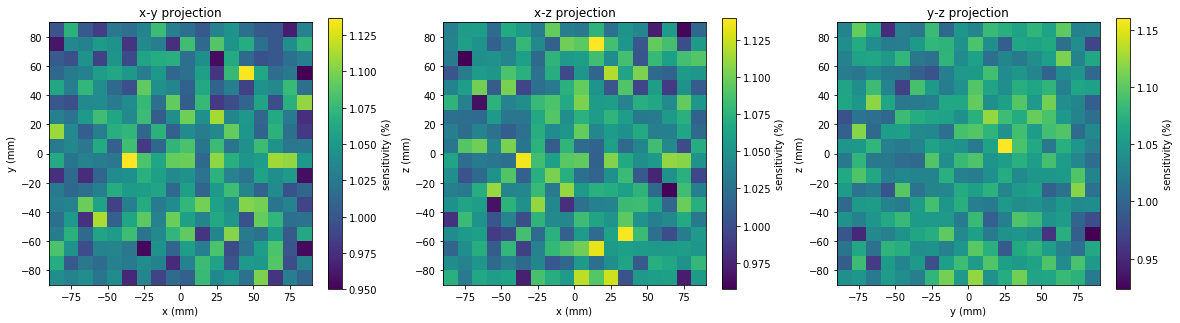

In [10]:
# Histogram the vertices from which coincidences were observed to produce the sensitivity mat
smatrix, _ = np.histogramdd(pts,bins=[xbins,ybins,zbins])
smatrix /= NPTS
plot_projections(smatrix,nbins_xy,nbins_z,FOV_XY,FOV_Z)

## Save the sensitivity matrix in a format that is compatible for use in reconstruction with the specified FOV and N-voxel parameters

sigma/mean of entire histogram is 0.026903323742867365


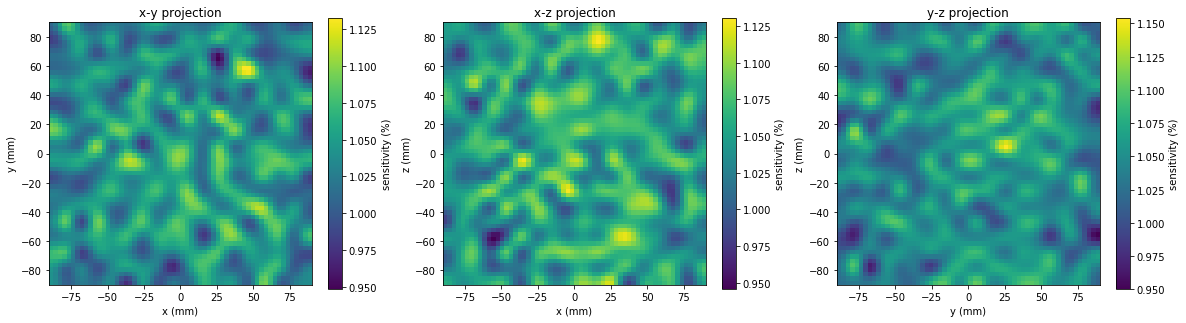

In [11]:
smatrix_save = zoom(smatrix, (NXY/nbins_xy, NXY/nbins_xy, NZ/nbins_z))
plot_projections(smatrix_save,NXY,NZ,FOV_XY,FOV_Z)
np.savez('petalo_fullbody_smatrix.npz',smat=smatrix_save)